In [1]:
using Pkg
using JLD
using Plots, LaTeXStrings
using LinearAlgebra
using DifferentialEquations
using Plots.PlotMeasures

\begin{equation}
    \left\lbrace \begin{array}{lllll}
    \dot{x}(t) &= \big(M(s(t))-uI_n+\varepsilon Z\big)x(t) + \theta H(x(t)), \\ \\
     \dot{s}(t) &= - \displaystyle\sum_{j=1}^n\frac{ \mu_j(s(t))x_j(t)}{Y_j}+ u(s_{in}-s(t)).
    \end{array} \right.
\end{equation}

## Model analysis

**Parameters:**

In [2]:
n = 5 

a = [i for i in 1:n] 
b = [i^2 for i in 1:n]  

Y = ones(n)
s_in = 35.0

d = [-1; [-2 for i in 1:(n-2)]; -1]
d1 = [1 for i in 1:(n-1)]
matrix_Z = SymTridiagonal(d, d1);
matrix_H = tril(ones(n,n),-1)+triu(-ones(n,n),1);

In [3]:
# import functions of the model
include("functions.jl");

**Simulation of the kinetics $\mu_i(s)$**

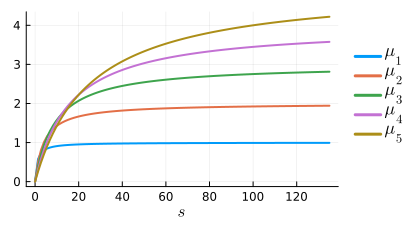

In [4]:
Ns = 100
s_vector = range(0, stop=s_in+100, length=Ns)
mu_labels = [L"\mu_%$i" for i in 1:n]
mu_values =  [ [μ(s,i) for s in s_vector] for i in 1:n ];
label = reshape(mu_labels[1:n],(1,:))
p = plot(s_vector, mu_values, label=label, lw=2, size=(420, 225),
        legendfont = font(12), xlabel=L"s",grid=true, 
        background_color_legend="white",fg_legend = :false, 
        legend=:outerright)

**Simulation of a solution to (1)**

In [5]:
u = 1.5
ε = 0.01
θ = 0.01

y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n

tf = 120.0
sol = solvePCS(f,y0,tf,u,ε,θ);

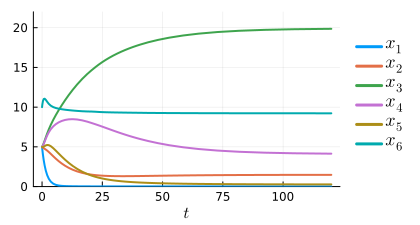

In [6]:
x_labels = permutedims([L"x_%$i" for i in 1:n+1])
p = plot(sol.t, transpose(sol[:,:]), label=x_labels, lw=2, size=(420, 225),
        legendfont = font(12), xlabel=L"t",grid=true, background_color_legend="transparent", 
        legend=:outerright, fg_legend = :false, ylimits=(0,22))

## Stability analysis

**Computation of the steady states**

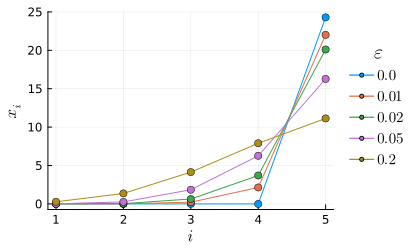

In [7]:
u = 1.5
θ = 0.2
y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n
tf = 1e5; # large final time to reach the steady state
tol_s_state = 1e-10 # tolerance for the steady dynamics

ε_list = [0.0, 0.01, 0.02, 0.05, 0.2]
Matrix_ss_ε = Array{Float64}(undef, length(ε_list), n) 

for (j,ε) in pairs(ε_list)
    sol = solvePCS(f,y0,tf,u,ε,θ); # solve the ode
    x_s, s_s = sol[1:n,end],  sol[n+1,end] # recover the steady states
    Matrix_ss_ε[j,:] = x_s
    # confirm that the dynamics at the steady state are zero
    error_s_state = sum([((μ(s_s,i) - u) * x_s[i]) + M(θ,ε,x_s,s_s,i) for i in 1:n])+dS(x_s, s_s, u)
    if error_s_state>tol_s_state
        println(ε)
    end
end

index = [i for i in 1:n]
ε_labels = [ L"%$e" for e in ε_list]
label = reshape(ε_labels,(1,:))
p = plot(index, transpose(Matrix_ss_ε), marker=(:circle,4), label=label, 
        lw=1, size=(420, 250),legendfont = font(10), xlabel=L"i", ylabel=L"x_i",
        grid=true, legend=:outerright, legend_title=L"\varepsilon",legendtitlefontsize = 13,
        background_color_legend="white",fg_legend = :false)


**Robustness with respect to the initial condition**

_We compute $x^*(u,\varepsilon,\theta)$ steady states of (1) for different values of $x(0)$ and $s(0)$ and check if it vary. We take randomly 100 initial conditions in the set $(0,100]^n \times [0,s_{in}]$. We exclude the case $x(0)=0$ as we know it leads to washout._

In [8]:
u = 1.5
ε = 0.01
θ = 0.01
tf = 1e5 # large final time to reach the steady state
tol_s_state = 1e-10 # tolerance for the steady dynamics
tol_robustness = 1e-8 # tolerance for robustness (difference between steady states)
len = 1000 # number of initial conditions to test

# compute example steady state
y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n
sol = solvePCS(f,y0,tf,u,ε,θ) # solve the ode
y_s = sol[:,end] # recover the steady states y=(x,s)

for k in 1:len
    # find a random inital condition
    x0 = rand(1e-3:100, n) 
    s0 = rand(0:s_in, 1) 
    y0 = vcat(x0,s0)
    # compute the steady state 
    sol = solvePCS(f,y0,tf,u,ε,θ) # solve the ode
    y = sol[:,end] # recover the steady states
    if norm(y-y_s)>tol_robustness
        println(y0)
    end
end

## Optimization analysis

\begin{equation}
\tag{2}
    \left\lbrace \begin{array}{lllll}
    &\displaystyle\max_{u\in [0, u_{\max}]} \ \ P\big(x,u\big) \;  
    \\
    \\
    \text{s.t.}&\\
    &0 = \big(M(s)-uI_n+\varepsilon Z\big)x + \theta H(x), \\
    \\
       & 0 = - \displaystyle\sum_{j=1}^n\frac{ \mu_j(s)x_j}{Y_j}+ u(s_{in}-s),\\
    \\
      &S(x)  \leq \alpha,
    \end{array}
    \right.
\end{equation}

**Computation of steady states $x^*$ and $P(x^*,u^*)$, $S(x^*)$, for different values of $u$** 

In [9]:
ε = 0.01
θ = 0.02
y0 = 5*ones(n+1) 
y0[n+1] = s_in-5*n
tf = 1e5  # large final time to reach the steady state

len = 300 # u grid size 
u_list = range(0, stop=3, length=len)
x_list = Array{Float64}(undef, len, n)
Sx_list, Px_list = zeros(len), zeros(len)

for (k,u) in pairs(u_list)
    # compute the steady state
    sol = solvePCS(f,y0,tf,u,ε,θ)
    x = sol[1:n,end]
    # save the value of x^* and S(x^*), P(x^*,u^*)
    x_list[k,:], Sx_list[k], Px_list[k],  = x, S(x), P(u,x)
    # confirm that the dynamics are the steady state are zero
    s = sol[n+1,end]
    error_s_state = sum([((μ(s,i) - u) * x[i]) + M(θ,ε,x,s,i) for i in 1:n])+dS(x, s, u)
    if error_s_state>tol_s_state
        println(ε)
    end
end;

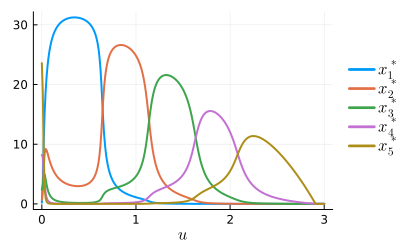

In [10]:
x_labels = permutedims([L"x^*_%$i" for i in 1:n+1])
p = plot(u_list, x_list, label=x_labels, lw=2, size=(420, 250),
        legendfont = font(11), xlabel=L"u",grid=true, 
        background_color_legend="transparent", 
        legend=:outerright, fg_legend = :false)

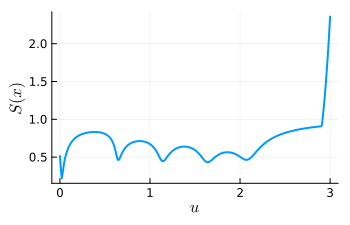

In [11]:
p = plot(u_list,Sx_list, lw=2, xlabel=L"u", ylabel=L"S(x)",
        size=(350, 225),legend=false)

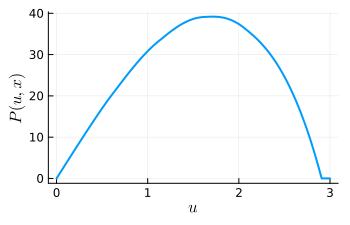

In [12]:
p = plot(u_list,Px_list, lw=2, xlabel=L"u", ylabel=L"P(u,x)",
        size=(350, 225),legend=false)

**Find the solution to (2) by extensive search for different values of $\alpha$**

In [13]:
e = 0.01
o = 0.02
y0 = 5*ones(n+1)
y0[n+1] = s_in-5*n
tf = 75.0

α_min = 1/n 
α_max = 1.0
len = 40 # α grid size
α_list = range(α_min, α_max, len)
OF_static = Array{Float64}(undef, len, 3) # array to save [J(u),S(x(T)),α]

for i in 1:len
    α = α_list[i]
    index_u_max = 0
    P_max = 0.0 
    # find the u value that fullfils S(T)≤u_max and maximizes P(x,u)
    for (k,Sx) in pairs(Sx_list)
        if Sx<=α
            P_x = Px_list[k]
            if P_x>P_max
                index_u_max = k
                P_max = P_x
            end 
        end
    end 
    # save the results
    if index_u_max > 0 # this means that there is a feasible solution
        u = u_list[index_u_max]
        sol = solvePCS(f,y0,tf,u,e,o); # simulate the trajectories 
        t, x  = sol.t, sol[1:n,:];
        J = 0
        for k in 1:(length(t)-1)
            J += (t[k+1]-t[k])*(P(u,x[:,k])+P(u,x[:,k+1]))/2
        end
        S_T = S(x[:,length(t)])
    else
        J, S_T = NaN, NaN
    end
    OF_static[i,:] = [J, S_T, α]
end

In [14]:
# load the dynamic optimization results to compare
OF_dynamic = load("sol_dyn.jld")["OF_list"] ;

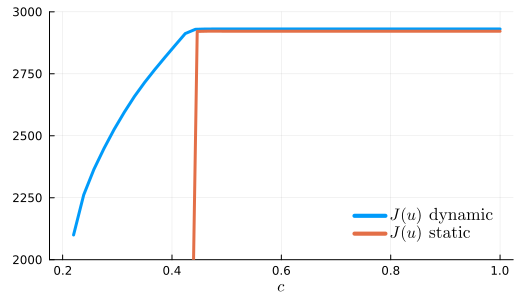

In [15]:
x_1 = OF_dynamic[:,3]
x_2 = OF_static[:,3]
y_1 = OF_dynamic[:,1]
y_2 = OF_static[:,1]
p = plot( [x_1,x_2], [y_1,y_2], lw=3, xlabel=L"c" ,
            label=[L"J(u)"*" dynamic" L"J(u)"*" static"],
            fg_legend = :false,ylimits=(2000,3000), 
            size=(525,300), left_margin = 1mm, 
            background_color_legend="transparent",
            legendfont = font(11,"Computer Modern"))